In [1]:
from astropy.table import Table
import numpy as np
import argparse
from jax import jit
import itertools
from scipy import interpolate

from Payne.jax.genmod import GenMod
from runscripts.runUTPcomp import getdata

import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

import os
import csv
%matplotlib inline

In [2]:
specNN = './models/specNN/modV0_spec_LinNet_R42K_WL510_535_wvt.h5'
photNN = './models/photNN/'
NNtype = 'LinNet'
mistNN = './models/mistNN/mistyNN_2.3_v256_v0.h5'
SBlib  = './models/specNN/c3k_v1.3.sed_r500.h5'

def planck(wav, T):
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    wave_i = wav*(1E-10)
    a = 2.0*h*c**2
    b = h*c/(wave_i*k*T)
    intensity = a/ ( (wave_i**5) * (np.exp(b) - 1.0) )
    return intensity

from scipy import constants
speedoflight = constants.c / 1000.0

# useful constants
# speedoflight = 2.997924e+10
speedoflight_kms = 2.997924e+5
speedoflight_nms = 2.997924e+17
lsun = 3.846e33
pc = 3.085677581467192e18  # in cm
jansky_cgs = 1e-23
# value to go from L_sun to erg/s/cm^2 at 10pc
log_rsun_cgs = np.log10(6.955) + 10.0
log_lsun_cgs = np.log10(lsun)
log4pi = np.log10(4 * np.pi)

rng = np.random.default_rng()

In [3]:
# make spectral prediction
data_p = getdata(spec='synth_spec_RV-3.csv', phot='synth_phot_g4.306.csv')
data_s = getdata(spec='synth_spec_RV18.csv', phot='synth_phot_g4.274.csv')

# make sure the wavelengths are the same
np.where(data_p['spec']['obs_wave'] != data_s['spec']['obs_wave'])
waves = data_p['spec']['obs_wave']

In [4]:
logr_p = 1.723
logr_s = 1.504

Teff_p = 9700
Teff_s = 7020

radius_p = 10.0**logr_p
radius_s = 10.0**logr_s

R = (
    (planck(waves,Teff_p) * radius_p**2.0) / 
    (planck(waves,Teff_s) * radius_s**2.0)
     )

speccomp = (data_p['spec']['obs_flux'] + R * data_s['spec']['obs_flux']) / (1.0 + R)
speccomp[:5]

1.0169512204274878
1.0163734016817096
1.015632399082617
1.014977227925742
1.0145990630978554


In [57]:
# sanity checks
print(np.where(R<0))
print(np.where(R<1))

(array([], dtype=int64),)
(array([], dtype=int64),)


In [58]:
# add noise, setting seed for reproducibility
np.random.seed(0)

# mu and sigma come from hectochelle data:
# file: data_ngc6819_2010.0921_ngc6819_sep2010_1.7137.h5
# target id: 2076392838230907392
mu, sigma = 0.055402016862253524, 0.004453214396949145
noise = np.random.normal(mu, sigma, len(speccomp))
speccomp = speccomp + noise
print(speccomp[:5])

       flux       
------------------
1.0802089405937765
1.0735574043853071
1.0753929460265312
 1.080358422644705
 1.078317716088982


(5160.0, 5190.0)

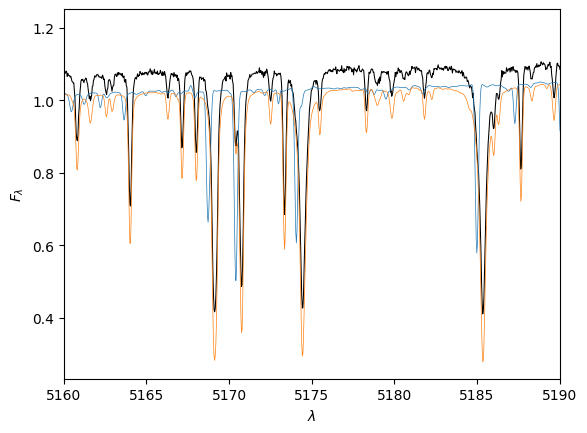

In [59]:
fig, ax = plt.subplots()
ax.plot(waves, speccomp, ls='-',lw=0.75,c='k',zorder=0)
# ax.plot(data_p['spec']['obs_wave'], data_p['spec']['obs_flux']+flux2_interp, ls='-',lw=0.5,c='C3',zorder=0)
ax.plot(waves, data_p['spec']['obs_flux'], ls='-',lw=0.5,c='C0',zorder=1)
ax.plot(waves, data_s['spec']['obs_flux'], ls='-',lw=0.5,c='C1',zorder=1)

ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$F_\lambda$')

ax.set_xlim(5160,5190)

In [60]:
# make phot prediction
for i in data_p['phot'].keys():
    print(i)

phot_p = [data_p['phot'][xx][0] for xx in data_p['phot'].keys()]
phot_s = [data_s['phot'][xx][0] for xx in data_s['phot'].keys()]
print(phot_p, len(phot_p))

photcomp = (
    [-2.5 * np.log10( 10.0**(-0.4 * m_p) + 10.0**(-0.4 * m_s) )
     for m_p,m_s in zip(phot_p,phot_s)
     ] 
)

WAVE_d = {'GaiaDR3_G': 6217.59,
        'GaiaDR3_BP': 5109.71,
        'GaiaDR3_RP': 7769.02,
        '2MASS_J': 12350.0,
        '2MASS_H': 16620.0,
        '2MASS_Ks': 21590.0,
        'PS_g': 4775.6,
        'PS_r': 6129.5,
        'PS_i': 7484.6,
        'PS_z': 8657.8
       }

WAVE = np.array([ii for ii in WAVE_d.values()])
# (len(WAVE_d.values()),
# len(photcomp))

GaiaDR3_G
GaiaDR3_BP
GaiaDR3_RP
2MASS_J
2MASS_H
2MASS_Ks
PS_g
PS_r
PS_i
PS_z
[0.7051980448654671, 0.8847639389257242, 0.3847025968294675, 0.03322588853425579, -0.04551905785571364, -0.0963883081763246, 0.8569298402963401, 0.7550602917188902, 0.7306526350940885, 0.7415380494522168] 10


In [61]:
# make some errors (taken from the known SB2 Gaia DR3 2076392838230907392)
emags = [0.05000091916311386,
         0.05004763662644478,
         0.050012894094444295,
         0.07733692547677395,
         0.08683893326204858,
         0.10121264701645077,
         0.020829461749839007,
         0.02065512096136038,
         0.020870045165005097,
         0.020915354323712318
        ]

Text(0, 0.5, 'Mag.')

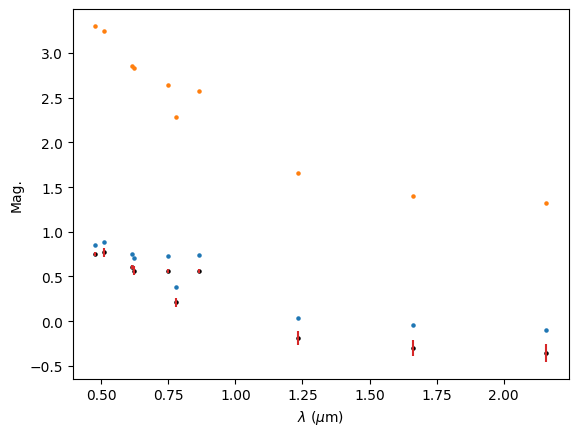

In [62]:
fig, ax = plt.subplots()

for wavelength, mag, err in zip(WAVE, photcomp, emags):
    ax.scatter(wavelength/1E+4, mag, s=5, c='k',zorder=0)
    ax.errorbar(wavelength/1E+4, mag, yerr=err, c='C3',zorder=1)

ax.scatter(WAVE/1E+4, phot_p, s=5, c='C0', zorder=1)
ax.scatter(WAVE/1E+4, phot_s, s=5, c='C1', zorder=1)

ax.set_xlabel(r'$\lambda$ ($\mu$m)')
ax.set_ylabel(r'Mag.')

In [ ]:
# output composite spectrum to csv
with open(f'synth_speccomp.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['wave', 'flux', 'eflux'])

    for row in zip(waves, speccomp+noise, noise):
        # print(row)
        csv_out.writerow(row)
print(f'synthetic composite spectrum output to /etc/demo_smes/synth_speccomp.csv')

In [ ]:
# output composite photometry to csv
with open(f'synth_photcomp.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['band', 'mag', 'emag'])

    for row in zip(WAVE_d.keys(), photcomp, emags):
        # print(row)
        csv_out.writerow(row)
print(f'synthetic composite photometry output to /etc/demo_smes/synth_photcomp.csv')

In [ ]:
Table.read('synth_photcomp.csv')[:5]

In [ ]:
# test the getddata function on the composite spec & phot I made above
from runUTPbinary_synth import getdata as getdata_synth
test_data = getdata_synth()
test_data

In [41]:
# read in the composite spectrum I generated above
synth_spec = Table.read('data/synth_speccomp.csv')
wave = synth_spec['wave']
flux = synth_spec['flux']
eflux = synth_spec['eflux']

# check for nans
print(f'nans in wavelength:\n{np.where(np.isnan(wave) == True)}\n')
print(f'nans in flux:\n{np.where(np.isnan(flux) == True)}\n')
print(f'nans in eflux:\n{np.where(np.isnan(eflux) == True)}\n')

# check for 0's in flux and eflux
print(f'0\'s in flux:\n{flux[flux < 0.05]}\n')
print(f'0\'s in eflux:\n{eflux[eflux < 0.04]}')

nans in wavelength:
(array([], dtype=int64),)

nans in flux:
(array([], dtype=int64),)

nans in eflux:
(array([], dtype=int64),)

0's in flux:
flux
----

0's in eflux:
eflux
-----


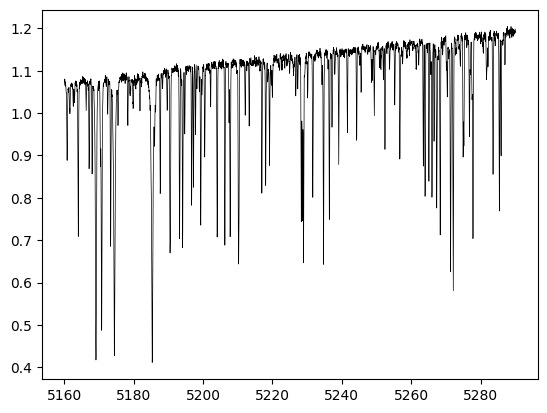

In [7]:
# plot the composite spectrum
fig, ax = plt.subplots()
ax.plot(wave, flux, lw=0.5, c='k')

# ax.set_xlim(5160, 5190)

# ax.set_xticks([])
# ax.set_yticks([])

# plt.savefig('Synthetic-Spectrum-Clean.png', dpi=500)

In [46]:
WAVE_d = {'GaiaDR3_G': 6217.59,
        'GaiaDR3_BP': 5109.71,
        'GaiaDR3_RP': 7769.02,
        '2MASS_J': 12350.0,
        '2MASS_H': 16620.0,
        '2MASS_Ks': 21590.0,
        'PS_g': 4775.6,
        'PS_r': 6129.5,
        'PS_i': 7484.6,
        'PS_z': 8657.8
       }

WAVE = np.array([ii for ii in WAVE_d.values()])

# read in the composite photometry I generated above
synth_phot = Table.read('data/synth_photcomp.csv')
synth_phot

# check for nans
# print(f'nans in wavelength:\n{np.where(np.isnan(wave) == True)}\n')
# print(f'nans in flux:\n{np.where(np.isnan(flux) == True)}\n')
# print(f'nans in eflux:\n{np.where(np.isnan(eflux) == True)}\n')

# check for 0's in flux and eflux
# print(f'0\'s in flux:\n{flux[flux < 0.05]}\n')
# print(f'0\'s in eflux:\n{eflux[eflux < 0.04]}')

band,mag,emag
str10,float64,float64
GaiaDR3_G,0.5621511158198917,0.05000091916311386
GaiaDR3_BP,0.7683125634784134,0.05004763662644478
GaiaDR3_RP,0.2107262510344232,0.050012894094444295
2MASS_J,-0.18603254430047844,0.07733692547677395
2MASS_H,-0.300139395332607,0.08683893326204858
2MASS_Ks,-0.35535683321118866,0.10121264701645077
PS_g,0.7485720601952955,0.020829461749839007
PS_r,0.6086221030325323,0.02065512096136038
PS_i,0.5583370421174051,0.020870045165005097


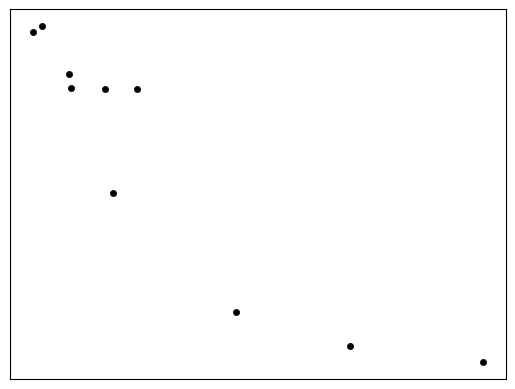

In [ ]:
fig, ax = plt.subplots()
ax.scatter(WAVE, mag, lw=0.5, c='k',s=20)

# ax.set_xlim(5160, 5190)

ax.set_xticks([])
ax.set_yticks([])

# plt.savefig('Synthetic-Photometry-Clean.png', dpi=500)

In [ ]:
# relearning how interpolation works:
plt.plot(data_p['spec']['obs_wave'], flux2_interp)
plt.plot(data_p['spec']['obs_wave'], data_p['spec']['obs_flux'])
plt.plot(data_p['spec']['obs_wave'], flux2_interp+data_p['spec']['obs_flux'])
plt.xlim(5200,5215)